In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.4.1+cu121


In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='./data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [12]:
from tqdm import tqdm

progress = tqdm(range(200))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    progress.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    progress.update()
progress.close()


Epoch: 200, Loss: 0.3810: 100%|██████████| 200/200 [00:01<00:00, 158.25it/s]


In [13]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


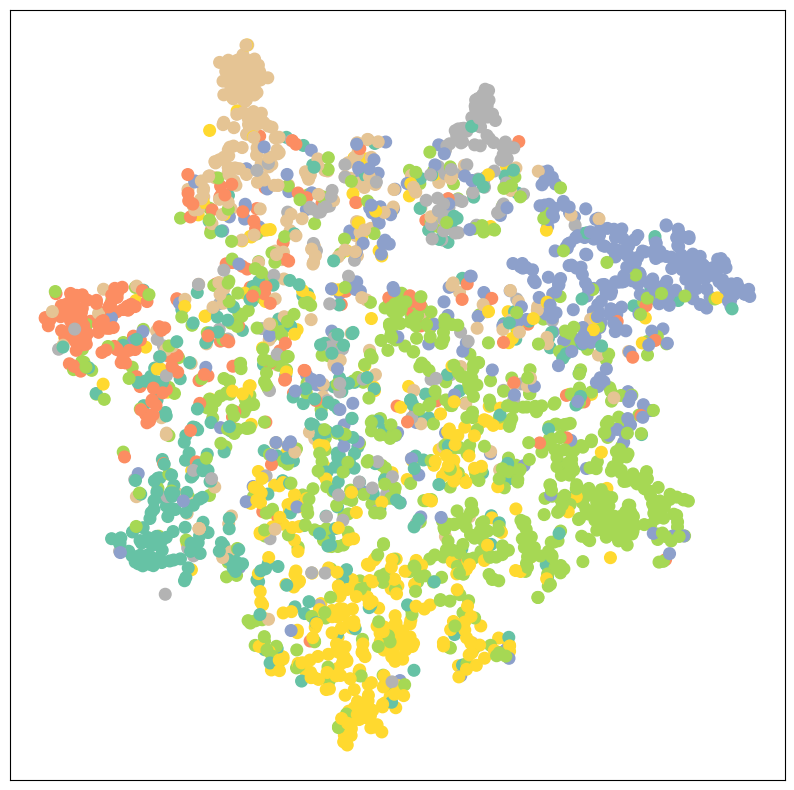

In [14]:
model.eval()
out = model(data.x)
visualize(out, color=data.y)

## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \sigma\left(\mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}\right)
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \sigma(\mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)})
$$

which does not make use of neighboring node information.

In [7]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


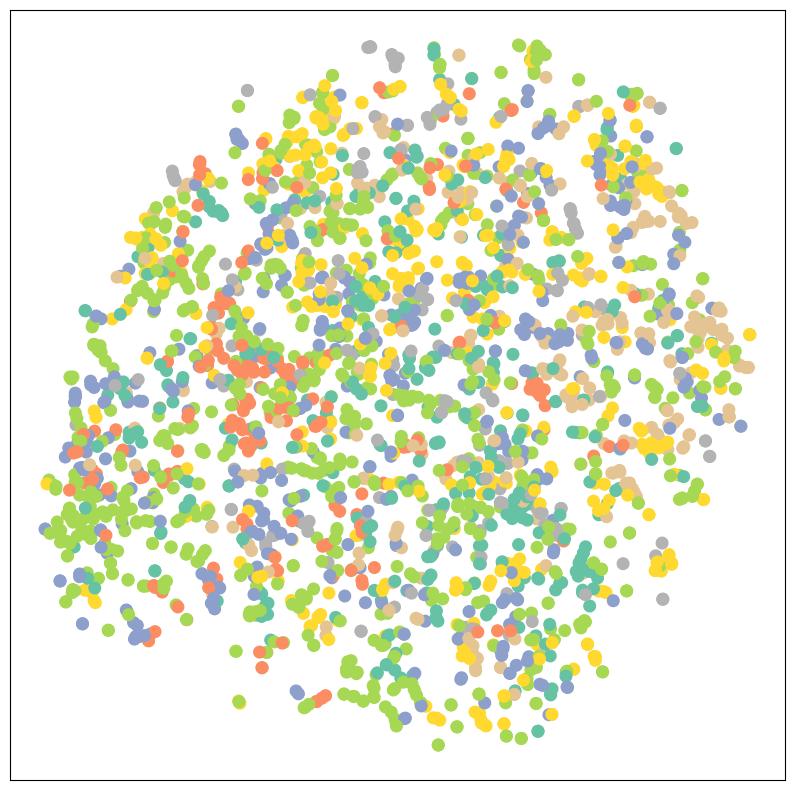

In [8]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [38]:
from tqdm import tqdm
epoch_num = 500
progress = tqdm(range(500))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return test_acc

loss_train = []
acc_val_list = []
acc_test_list = []

for epoch in range(1, epoch_num+1):
    loss = train()
    loss_train.append(loss.item())
    acc_val = test(data.val_mask)
    acc_test = test(data.test_mask)
    acc_val_list.append(acc_val)
    acc_test_list.append(acc_test)
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    progress.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {acc_val:.4f}, Test: {acc_test:.4f}')
    progress.update()
progress.close()

Epoch: 500, Loss: 0.1884, Val: 0.7940, Test: 0.8140: 100%|██████████| 500/500 [00:08<00:00, 57.65it/s]


In [40]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


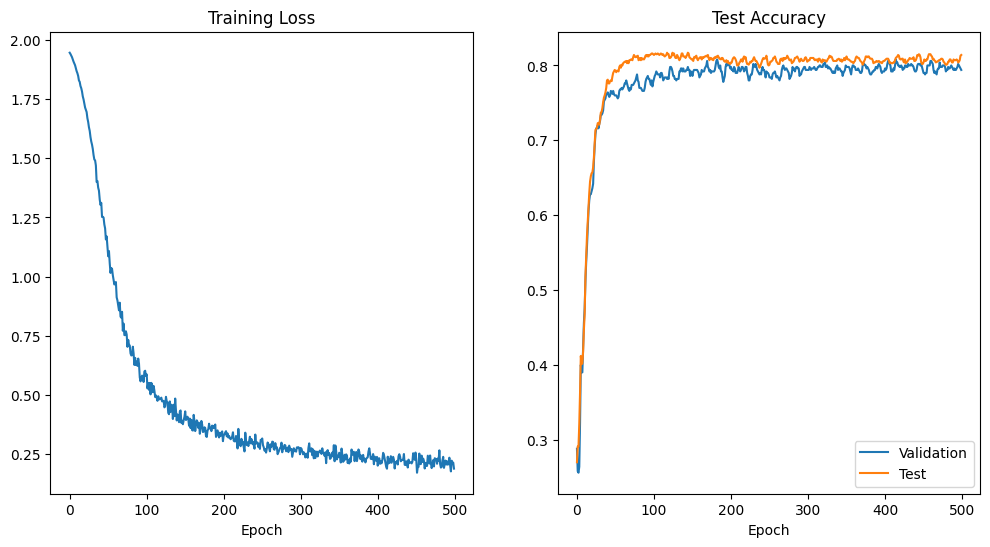

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(loss_train, label='Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training Loss')

ax[1].plot(acc_val_list, label='Validation')
ax[1].plot(acc_test_list, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Test Accuracy')
plt.legend()
plt.show()


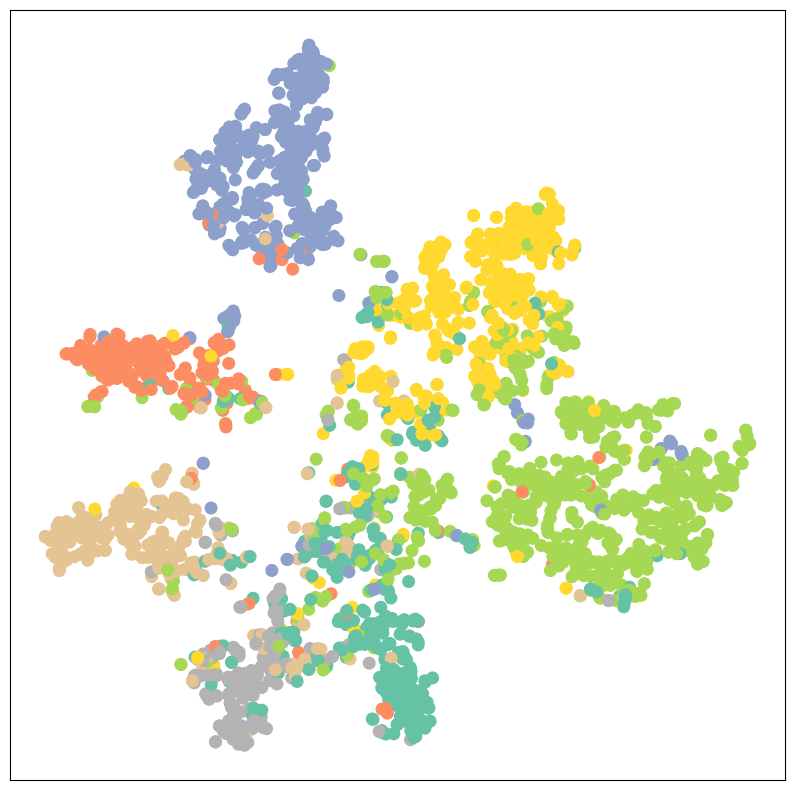

In [42]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Training a Graph Attention Network (GAT)

We can further improve the performance of our GNN by replacing the `GCNConv` layer with the [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) module.

The **GAT layer** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)) is defined as:

$$
\mathbf{x}_v^{(\ell + 1)} = \alpha_{v,v}^{(\ell)} \cdot \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)} + \sum_{w \in \mathcal{N}(v)} \alpha_{w,v}^{(\ell)} \cdot \mathbf{W}^{(\ell + 1)} \mathbf{x}_w^{(\ell)}
$$

where $\alpha_{w,v}^{(\ell)}$ denotes the attention coefficient between node $v$ and its neighbor $w$.



In [33]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


Epoch: 198, Loss: 0.5958, Val: 0.8060, Test: 0.8350:  40%|███▉      | 198/500 [00:23<00:10, 27.69it/s]

In [ ]:
model = GAT(hidden_channels=8, heads=8)

epoch_num = 500
progress = tqdm(range(epoch_num))

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

loss_train = []
acc_val_list = []
acc_test_list = []
for epoch in range(1, epoch_num+1):
      loss = train()
      val_acc = test(data.val_mask)
      test_acc = test(data.test_mask)
      loss_train.append(loss.item())
      acc_val_list.append(val_acc)
      acc_test_list.append(test_acc)
      # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
      progress.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
      progress.update()

progress.close()

Epoch: 198, Loss: 0.5958, Val: 0.8060, Test: 0.8350:  40%|███▉      | 198/500 [00:24<00:37,  7.95it/s]
Epoch: 500, Loss: 0.5918, Val: 0.7980, Test: 0.8230: 100%|██████████| 500/500 [00:19<00:00, 25.56it/s]


In [35]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8230


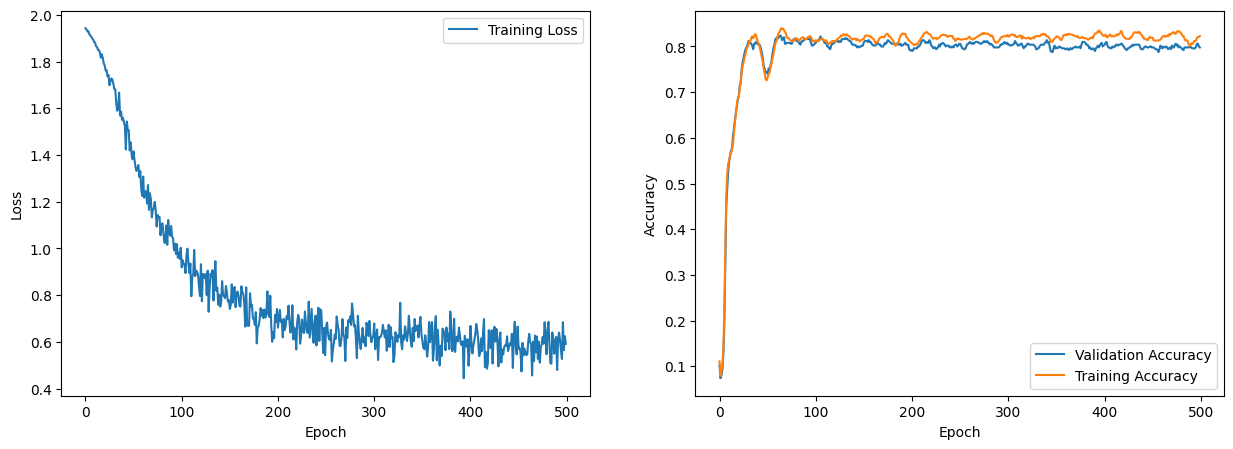

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(loss_train, label='Training Loss')
ax[1].plot(acc_val_list, label='Validation Accuracy')
ax[1].plot(acc_train_list, label='Training Accuracy')

ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].legend()
ax[1].legend()

plt.show()

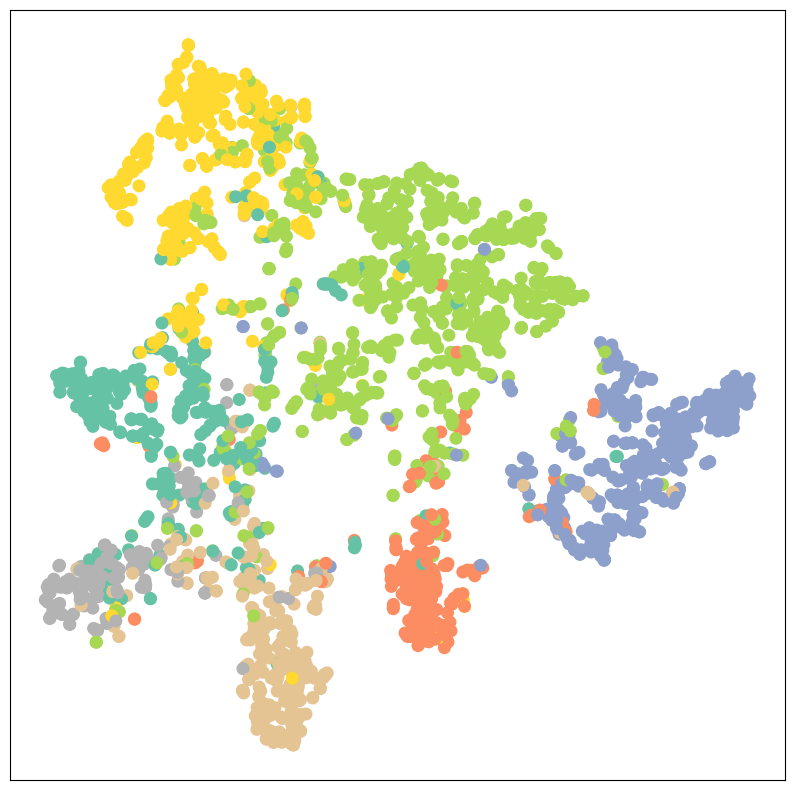

In [37]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Node to Vector Aggregation


Epoch: 100, Loss: 0.8255, Acc: 0.6950: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


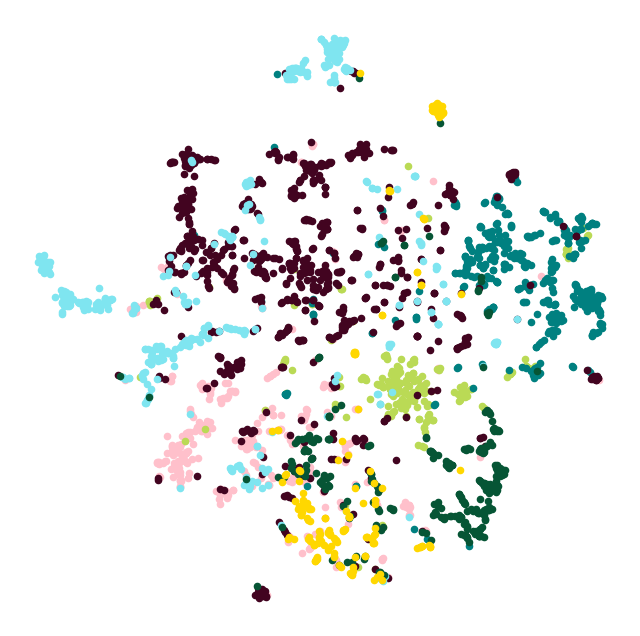

In [45]:
import os.path as osp
import sys

import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

from tqdm import tqdm

path = './data/Planetoid'
dataset = Planetoid(path, name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

progress = tqdm(range(100))

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    progress.set_description(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    progress.update()

progress.close()


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)

# Graph Classification with Graph Neural Networks

[Previous: Node Classification with Graph Neural Networks](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX)

In this tutorial session we will have a closer look at how to apply **Graph Neural Networks (GNNs) to the task of graph classification**.
Graph classification refers to the problem of classifiying entire graphs (in contrast to nodes), given a **dataset of graphs**, based on some structural graph properties.
Here, we want to embed entire graphs, and we want to embed those graphs in such a way so that they are linearly separable given a task at hand.

In [1]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [2]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [3]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [4]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [5]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7467, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 009, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 010, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 012, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 014, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 015, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 018, Train Acc: 0.7133, Test Acc: 0.8421
Epoch: 019, Train Acc: 0.7400, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.7467, Test Acc:

As multiple papers pointed out ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), applying **neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures**.
An alternative formulation ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)) omits neighborhood normalization completely and adds a simple skip-connection to the GNN layer in order to preserve central node information:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

As an exercise, you are invited to complete the following code to the extent that it makes use of PyG's `GraphConv` rather than `GCNConv`.
This should bring you close to **82% test accuracy**.

In [6]:
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GNN(hidden_channels=64)
print(model)

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [7]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.7333, Test Acc: 0.7895
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.7333, Test Acc: 0.8158
Epoch: 008, Train Acc: 0.7267, Test Acc: 0.8158
Epoch: 009, Train Acc: 0.7867, Test Acc: 0.8421
Epoch: 010, Train Acc: 0.7733, Test Acc: 0.8158
Epoch: 011, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 012, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 013, Train Acc: 0.7733, Test Acc: 0.8421
Epoch: 014, Train Acc: 0.7733, Test Acc: 0.7895
Epoch: 015, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 016, Train Acc: 0.7667, Test Acc: 0.7632
Epoch: 017, Train Acc: 0.7933, Test Acc: 0.8421
Epoch: 018, Train Acc: 0.7867, T